### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping),<span style="background-color: #FFFF00"> identify features in the data related to job postings that can distinguish job titles from each other.</span> There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


In [1]:
from bs4 import BeautifulSoup
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import re

In [2]:
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, \
mean_squared_error, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from sklearn.cluster import KMeans

In [3]:
import warnings
warnings.filterwarnings('ignore')

### NLP and more cleaning specific to Q2

In [4]:
df = pd.read_pickle("./allcleaned.pkl")

In [5]:
# unlike Q1, we shall keep all the data we scraped (including those that don't have salaries)
df.shape

(2945, 17)

In [6]:
df.portal.value_counts()

Indeed           2154
CareersFuture     791
Name: portal, dtype: int64

run vectorizer on jd first.

In [7]:
# it's one giant string. cool.
df.jd[51]

'Roles & ResponsibilitiesPalo IT is an innovation & agile development company. From Design Research to DevOps, we are in the business of end-to-end development of breakthrough digital experiences. As a community of innovators and developers, we also aim at renewing the way organizations operate, promoting sustainable business agility, user-centricity and open collaboration while having fun doing it.  Started in Paris in 2009 and with offices in Singapore, Hong Kong and Mexico, we are looking for our next superstar to join our exciting team in Singapore.  At Palo IT, our employees are not widgets. They are in the center of all our projects and successes. We offer an exciting and creative working environment, with endless opportunities to develop your skills, travel and take your career to the next level. Get in touch to find out more!  Your profile & role on the project  YOU:  \uf0a7 Thrive on challenge. When was the last time you fail?  \uf0a7 Are curious & always learning. What are yo

In [8]:
def cleanrd1(text):
    text = text.lower()
    # removes carriage returns
    text = re.sub('/(\r\n)+|\r+|\n+|\t+/i', ' ', text)
    # remove everything NOT in the brackets (with caret)
    text = re.sub(r"[^a-zA-Z ]"," ",text)
    return text

clean1 = lambda x: cleanrd1(x)
# df['text'] = df['jd'].apply(clean1)

In [9]:
df['text'] = df.jd.apply(clean1)

In [10]:
df.text[51]

'roles   responsibilitiespalo it is an innovation   agile development company  from design research to devops  we are in the business of end to end development of breakthrough digital experiences  as a community of innovators and developers  we also aim at renewing the way organizations operate  promoting sustainable business agility  user centricity and open collaboration while having fun doing it   started in paris in      and with offices in singapore  hong kong and mexico  we are looking for our next superstar to join our exciting team in singapore   at palo it  our employees are not widgets  they are in the center of all our projects and successes  we offer an exciting and creative working environment  with endless opportunities to develop your skills  travel and take your career to the next level  get in touch to find out more   your profile   role on the project  you     thrive on challenge  when was the last time you fail     are curious   always learning  what are you up to ri

In [11]:
corpus = [t for t in df.text]

In [12]:
from nltk.corpus import stopwords
# import stopwords with option of adding more customized ones later 
stop = stopwords.words('english')

In [13]:
# let's expand the scope of the ngram and max features since Q2 is all about words
tvec = TfidfVectorizer(stop_words=stop, ngram_range=(1, 3), max_df=0.9, max_features=30000)

In [14]:
# builds vocab using fit and transforms words into numbers w transform
tvec.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=30000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
X = tvec.transform(corpus)

In [16]:
Xt = pd.DataFrame(X.todense(), 
                    columns=tvec.get_feature_names(), index = df.index)

In [17]:
Xt.shape

(2945, 30000)

In [18]:
Xt.sum().sort_values(ascending=False).head(20)

data            153.139680
business        119.249533
team             71.810093
work             67.171243
management       66.683960
skills           66.521314
requirements     55.823152
sales            55.326251
support          55.246495
development      53.481557
analytics        52.294132
project          51.089141
knowledge        50.801397
analysis         49.134841
solutions        48.605031
learning         47.903782
strong           47.715965
ability          46.572394
working          46.330188
technical        44.097421
dtype: float64

In [19]:
# let's also transform job title into clean text
df['text2'] = df.jobtitle.apply(clean1)

In [20]:
df.text2[101]

'senior associate  data and analytics  advisory'

In [21]:
corpus2 = [t for t in df.text2]

In [22]:
cvec = CountVectorizer(stop_words=stop, ngram_range=(1, 2), max_df=0.9, max_features=20000)

In [23]:
cvec.fit(corpus2)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=20000, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
Xj = cvec.transform(corpus2)

In [25]:
Xj = pd.DataFrame(Xj.todense(), 
                    columns=cvec.get_feature_names(), index = df.index)

In [26]:
Xj.shape

(2945, 5540)

In [27]:
Xj.sum().sort_values(ascending=False).head(20)

analyst             1219
data                 715
business             601
senior               371
business analyst     338
manager              324
engineer             301
scientist            279
data scientist       234
associate            141
operations           134
analytics            133
consultant           128
data analyst         123
technology           109
research             109
singapore            105
developer             96
intelligence          96
lead                  92
dtype: int64

In [28]:
#df.rank pulls up function, so rename to avoid clash
df.rename(columns={'rank': 'ranked'}, inplace=True)

In [29]:
medsal = np.median(~df.avgsalary.isnull())
medsal

1.0

In [30]:
# replace null avgsalary with median
df.avgsalary.fillna(medsal, inplace=True)

In [31]:
df.avgsalary.isnull().sum()

0

In [32]:
df.elapsed = pd.to_numeric(df.elapsed)

In [33]:
# check for nulls
df.isnull().sum()

advertiser         0
avgsalary          0
district        2306
elapsed            0
industry        2154
jd                 0
jobtitle           0
jobtype         1646
portal             0
searchstring       0
seniority       2154
source             0
employees         16
firmsize           0
function        2154
ranked          2154
level           2154
text               0
text2              0
dtype: int64

In [34]:
# impute median rank to null ranked rows as this is numerical and will cause problems in modelling
# later if not handled
np.median(~df.ranked.isnull())

0.0

In [35]:
df.ranked.fillna(np.median(~df.ranked.isnull()), inplace=True)

In [36]:
# for others, replace with 'None' as these are categoricals
todrop = ['district','industry', 'jobtype']
for t in todrop:
    df[t].fillna('None',  inplace=True)

In [37]:
# create final dataframe for classification exercise 

In [38]:
df.firmsize = df.firmsize.astype(float)

In [39]:
X = df.select_dtypes(include='number')
X.head()

,avgsalary,elapsed,employees,firmsize,function,ranked,level
0,9000.0,0.0,20000.0,3.0,0.0,3.0,3.0
1,5100.0,0.0,1.0,0.0,2.0,2.0,0.0
2,17500.0,0.0,1.0,0.0,3.0,3.0,0.0
3,10500.0,0.0,1.0,0.0,4.0,8.0,4.0
4,8500.0,0.0,1.0,0.0,2.0,7.0,5.0


In [40]:
X = X.drop(['function','level','employees'], axis=1)
X.shape

(2945, 4)

In [41]:
# some jobs belong to multiple industries, so let's split the industry variable
dummy = df.industry.str.strip().str.get_dummies(sep=',')
#industry_split = df.industry.str.strip().str.split(',', expand=True).stack()

In [42]:
dummy.shape

(2945, 64)

In [43]:
X = pd.concat([X, dummy], axis=1)
X.shape

(2945, 68)

In [44]:
# columns to convert into dummy variables 
dummies = ['district', 'jobtype', 'portal', 'searchstring' ]   

In [45]:
dummy = pd.get_dummies(df[dummies], prefix=dummies, drop_first=True)
X = pd.concat([X, dummy], axis=1)
X.shape

(2945, 107)

In [46]:
# check for NAs
X.columns[X.isnull().any()]

Index([], dtype='object')

In [47]:
# prefix jd word columns with 'jd' for ID purposes
Xt.columns = 'jd_' + Xt.columns
Xt.shape

(2945, 30000)

In [48]:
X = pd.concat([X, Xt], axis=1)

In [49]:
# prefix jobtitle word columns with 'jt' for ID purposes
Xj.columns = 'jt_' + Xj.columns
Xj.shape

(2945, 5540)

In [50]:
#X = pd.concat([X, Xj], axis=1)

In [51]:
X.shape

(2945, 30107)

In [52]:
Xj.sum().sort_values(ascending=False)[:10]

jt_analyst             1219
jt_data                 715
jt_business             601
jt_senior               371
jt_business analyst     338
jt_manager              324
jt_engineer             301
jt_scientist            279
jt_data scientist       234
jt_associate            141
dtype: int64

In [53]:
df.text2.head()

0      big data engineer  financial services 
1                      big data administrator
2                         analytics architect
3    technical solutions architecture manager
4                senior etl and data engineer
Name: text2, dtype: object

In [54]:
df.to_pickle('./Q2premodel.pkl')

### MODELLING

<div class="alert alert-warning">
This appears to be an unsupervised learning problem, as we do not have specific values of y to test as yet. 

In [55]:
# scale features
ss= StandardScaler()

Xs = ss.fit_transform(X)


<div class="alert alert-warning">
    1. Before we do anything else, what is the optimal k for k-means clustering? 

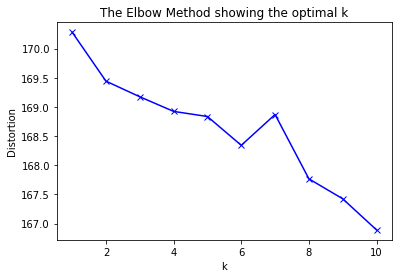

In [56]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Xs)
    kmeanModel.fit(Xs)
    distortions.append(sum(np.min(cdist(Xs, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Xs.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [56]:
# based on elbow graph above, try k=3
model = KMeans(n_clusters=3, random_state=60)

# Fitting Model
model.fit(Xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=60, tol=0.0001, verbose=0)

In [57]:
# Prediction on the entire data - can also use model.labels_
all_predictions = model.predict(Xs)

In [58]:
print(all_predictions)

[2 2 2 ... 2 2 2]


In [59]:
np.unique(all_predictions, return_counts=True)

(array([0, 1, 2]), array([  12,  133, 2800], dtype=int64))

In [60]:
df['prediction'] = all_predictions

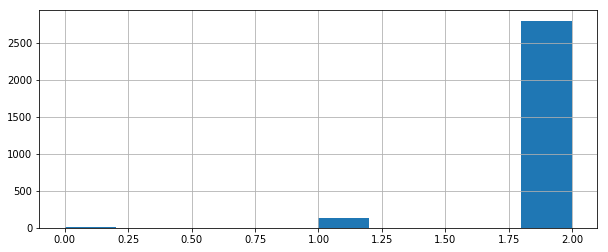

In [61]:
df.prediction.hist(figsize=(10,4), bins=10)

In [64]:
# data is heavily skewed to cluster 2. let's run random forest to see what features affect cluster 
# 2 the most

 <div class="alert alert-warning">
    2. Random Forest with cluster 2 as target variable y=1

In [62]:
y = np.where(all_predictions==2, 1, 0)

In [63]:
ranf_parameters = {
    'n_estimators': [100, 200, 400],
    'max_features': ['auto', 'log2'],
    'max_depth' : [4,6],
    'criterion' :['gini', 'entropy']
}

In [64]:
def gscv(method, prefix, cv, X,y):

    gridsearcher = GridSearchCV(method, param_grid=prefix,cv=cv, verbose=2, n_jobs=-1)
    result = gridsearcher.fit(X,y)

    #print('Best mean cross-validated score achieved:', result.best_score_)
    print('Best parameters:', result.best_params_)
    # this is the accuracy score ie. tp+tn/totpopn
    best = result.best_estimator_
    return best

In [65]:
rfpredict0 = gscv(RandomForestClassifier(), ranf_parameters, 5, Xs, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 28.3min finished


Best parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 400}


In [66]:
# Get numerical feature importances
importances = list(rfpredict0.feature_importances_)
# get coefficients
rfdf = pd.DataFrame(importances, index=X.columns, columns=['coef'])
# getting top features
rfdf.sort_values(by='coef', ascending=False)[:20]

,coef
jd_resilient infrastructure strategic,0.008623
jd_nimble resilient infrastructure,0.007522
jd_bank operational processes,0.007329
jd_ethnic national,0.006503
jd_citizenship marital,0.006283
jd_majority bank operational,0.005793
jd_operational processes inspire,0.005722
jd_technology people,0.005675
jd_empowers bank,0.005661
jd_bank operational,0.005429


<li>words from the JD dominated the top 20, but they don't offer much insight about the cluster core content. one or two exceptions could possibly be inclusion of specific wording in hiring policies and the need to be 'nimble' and 'efficient'. 
<li>also, since the cluster process produced a huge majority cluster (this was also true of k-means runs with k=4, k=8 and k=11 (not shown here)), the results are not very meaningful.

<li>let's try a more targeted approach. 

<div class="alert alert-warning">
    3. Logistic Regression to explore relationship between senior positions and job titles. 

In [56]:
# isolate all job titles containing the word 'senior'
y = np.where(df.text2.str.contains('senior'), 1, 0)

In [58]:
logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)}

In [59]:
lrsenior = gscv(LogisticRegression(), logr_parameters, 5, Xs, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 100.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 178.0min finished


Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [64]:
lrcoef = pd.DataFrame(lrsenior.coef_.T, index=X.columns, columns=['coef'])
lrcoef['abscoef'] = abs(lrcoef.coef)
lrcoef.sort_values(by='abscoef', ascending=False).head(20)

,coef,abscoef
jd_senior,0.932778,0.932778
jd_senior data,0.616512,0.616512
jd_senior analyst,0.481625,0.481625
jd_loosely,0.427203,0.427203
jd_demonstrate flexibility,0.401319,0.401319
jd_insights lead,0.367892,0.367892
jd_role senior,0.338503,0.338503
jd_skyscanner,0.332403,0.332403
jd_sales delivery,0.321293,0.321293
jd_lessons learned,0.299112,0.299112


words containing 'senior', and words like 'demonstrate flexibility', 'sales delivery' and 'insights lead' within a JD are the top words assoc with senior roles. 

<div class="alert alert-warning">
    4. Explore relationship between searchstrings and jobtitles.  

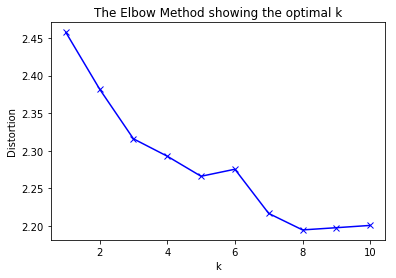

In [65]:
from scipy.spatial.distance import cdist
# use elbow technique to see if there are clusters within job titles
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Xj)
    kmeanModel.fit(Xj)
    distortions.append(sum(np.min(cdist(Xj, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Xj.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [69]:
df.searchstring.unique()

array(['Big Data', 'Business Analyst', 'Business Intelligence',
       'Database Administrator', 'Data Analyst', 'Data Engineer',
       'Data Scientist', 'Deep Learning', 'Machine Learning',
       'Python Developer', 'Data'], dtype=object)

In [70]:
# there is a clear kink at 9
model = KMeans(n_clusters=9, random_state=60)

# Fitting Model
model.fit(Xj)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=60, tol=0.0001, verbose=0)

In [71]:
# Prediction on the entire data - can also use model.labels_
all_predictions = model.predict(Xj)

In [72]:
print(all_predictions)

[5 1 1 ... 1 1 5]


In [73]:
df['sslabels'] = all_predictions

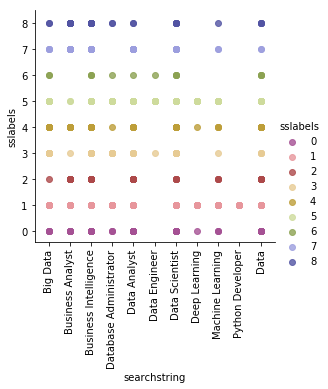

In [74]:
g = sns.lmplot(x = 'searchstring', y = 'sslabels', data = df, hue = 'sslabels', \
           height = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=90)
plt.show()

In [ ]:
# no special patterns observed

In [75]:
from sklearn.metrics import completeness_score
print(completeness_score(df.searchstring, all_predictions))
from sklearn.metrics import homogeneity_score
print(homogeneity_score(df.searchstring, all_predictions))

0.2840981593875318
0.2778153024594559


very poor results, indicating that different string searches do not produce JD descriptions which are very dissimilar. 

<div class="alert alert-warning">
    5. Runs k-means cluster analysis on 'data analyst' vs 'data scientist' roles to see if there is a difference in job requirements  

In [77]:
Xj['jt_data analyst'].sum()

123

In [78]:
y = np.where(Xj['jt_data analyst']==1, 0, None)

In [79]:
Xj['jt_data scientist'].sum()

234

In [80]:
y = np.where(Xj['jt_data scientist']==1, 1, y)

In [84]:
y = pd.Series(y)
temp = pd.concat([Xj, y], axis=1) 

In [85]:
Xdsda = temp.dropna(subset=[0])
ydsda = Xdsda.iloc[:,-1:].values
Xdsda = Xdsda.drop(0, axis=1)

In [86]:
ydsda = np.reshape(ydsda, (353,))

In [87]:
Xdsda.fillna(0, inplace=True)

In [88]:
# k = 2 for this run, since there are two classes
model = KMeans(n_clusters=2, random_state=60)

# Fitting Model
model.fit(Xdsda)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=60, tol=0.0001, verbose=0)

In [89]:
# Prediction on the entire data - can also use model.labels_
all_predictions = model.predict(Xdsda)

In [90]:
np.unique(all_predictions, return_counts=True)

(array([0, 1]), array([231, 122], dtype=int64))

In [91]:
from sklearn.metrics import completeness_score
print(completeness_score(ydsda, all_predictions))

from sklearn.metrics import homogeneity_score
print(homogeneity_score(ydsda, all_predictions))

0.015059117879005676
0.015101898241687768


very poor results, indicating that there is really no difference between the content of JDs for data scientists vis a vis data analyst roles. 